<a href="https://www.kaggle.com/code/zukhrakhongulomova/mental-health-in-tech?scriptVersionId=142418869" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.manifold import TSNE, MDS
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import make_column_selector as selector, ColumnTransformer

from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedoc

# Step 1: Data Preprocessing and Exploration

In [2]:
df = pd.read_csv('/kaggle/input/mental-health-in-tech-2016/mental-heath-in-tech-2016_20161114.csv')

data = pd.DataFrame(df)
len(data.columns)

63

## Exploring the Data

In [3]:
data.isna().sum()

Are you self-employed?                                                                  0
How many employees does your company or organization have?                            287
Is your employer primarily a tech company/organization?                               287
Is your primary role within your company related to tech/IT?                         1170
Does your employer provide mental health benefits as part of healthcare coverage?     287
                                                                                     ... 
What US state or territory do you live in?                                            593
What country do you work in?                                                            0
What US state or territory do you work in?                                            582
Which of the following best describes your work position?                               0
Do you work remotely?                                                                   0
Length: 63

### Renaming Columns

In [4]:
dict_new_columns = {
    'Are you self-employed?': 'Self Employed',
    'How many employees does your company or organization have?': 'Number of employees',
    'Is your employer primarily a tech company/organization?': 'Tech Company',
    'Does your employer provide mental health benefits as part of healthcare coverage?': 'MH Coverage',
    'Do you know the options for mental health care available under your employer-provided coverage?': 'MH Coverage Awareness',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?': 'MH Discussion',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?': 'MH Resources Provided',
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?': 'MH Anonimity',
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:': 'Medical Leave',
    'Do you think that discussing a mental health disorder with your employer would have negative consequences?': 'MH Discuission Neg Impact',
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'MH Discuission Coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'MH Discuission Supervisor(s)',
    'Do you feel that your employer takes mental health as seriously as physical health?': 'MH as PH',
    'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?': 'MH Coworker Reveal Neg Impact',
    'Do you feel that being identified as a person with a mental health issue would hurt your career?': 'MH Bad Impact on Career',
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?': 'MH Neg View of Coworkers',
    'How willing would you be to share with friends and family that you have a mental illness?': 'MH Sharing Freinds/Family',
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?': 'MH Bad Response',
    'Do you have a family history of mental illness?': 'MH Family History',
    'Have you had a mental health disorder in the past?': 'MH Disorder Past',
    'Do you currently have a mental health disorder?': 'Current MH Disorder',
    'Have you been diagnosed with a mental health condition by a medical professional?': 'MH Diagnos Proffesional',
    'Have you ever sought treatment for a mental health issue from a mental health professional?': 'MH Sought Proffes Treat',
    'What is your age?': 'Age',
    'What is your gender?': 'Gender',
    'What country do you live in?': 'Country',
    'What US state or territory do you live in?': 'US State',
    'What country do you work in?': 'Work Country',
    'What US state or territory do you work in?': 'Work US State',
    'Which of the following best describes your work position?': 'Work Position',
    'Do you work remotely?': 'Remote', 
    'Do you think that discussing a physical health issue with your employer would have negative consequences?': 'PH Discuission Neg Impact',
    'Do you have previous employers?': 'Prev Employers',
    'Have your previous employers provided mental health benefits?': 'Prev MH Benefits',
    'Were you aware of the options for mental health care provided by your previous employers?': 'MH Awarness Prev',
    'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?': 'Prev MH Discussion',
    'Did your previous employers provide resources to learn more about mental health issues and how to seek help?': 'Prev MH Resources Provided',
    'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?': 'Prev MH Anonimity',
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?': 'Prev MH Discuission Neg Impact',
    'Do you think that discussing a physical health issue with previous employers would have negative consequences?': 'Prev PH Discuission Neg Impact',
    'Would you have been willing to discuss a mental health issue with your previous co-workers?': 'Prev MH Discuission Coworkers',
    'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?': 'Prev MH Discuission Supervisor(s)',
    'Did you feel that your previous employers took mental health as seriously as physical health?': 'Prev MH as PH',
    'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?': 'Prev MH Coworker Reveal Neg Impact',
    'Would you be willing to bring up a physical health issue with a potential employer in an interview?': 'PH in Interview',
    'Why or why not?': 'Why/why not',
    'Would you bring up a mental health issue with a potential employer in an interview?': 'MH in Interview',
    'Why or why not?.1': 'Why/why not (1)',
    'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?': 'Less Reveal MH after observation',
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?': 'MH Effective Treatment',
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?': 'MH NOT Effective Treatment'
}

data.rename(columns=dict_new_columns, inplace=True)
data.columns

Index(['Self Employed', 'Number of employees', 'Tech Company',
       'Is your primary role within your company related to tech/IT?',
       'MH Coverage', 'MH Coverage Awareness', 'MH Discussion',
       'MH Resources Provided', 'MH Anonimity', 'Medical Leave',
       'MH Discuission Neg Impact', 'PH Discuission Neg Impact',
       'MH Discuission Coworkers', 'MH Discuission Supervisor(s)', 'MH as PH',
       'MH Coworker Reveal Neg Impact',
       'Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?',
       'Do you know local or online resources to seek help for a mental health disorder?',
       'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?',
       'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?',
       'If you have been diagnosed or treated for a mental healt

In [5]:
cols_to_drop = list(data.isna().sum() >= data.shape[0]/2)
data.drop(data.columns[cols_to_drop], axis=1, inplace=True)
len(data.columns)

50

### Dealing with Missing Values

In [6]:
mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mode_imputer.fit(data)
imputed_data = mode_imputer.transform(data)
imputed_df = pd.DataFrame(data=imputed_data, columns=data.columns)
imputed_df.isnull().sum()

Self Employed                         0
Number of employees                   0
Tech Company                          0
MH Coverage                           0
MH Coverage Awareness                 0
MH Discussion                         0
MH Resources Provided                 0
MH Anonimity                          0
Medical Leave                         0
MH Discuission Neg Impact             0
PH Discuission Neg Impact             0
MH Discuission Coworkers              0
MH Discuission Supervisor(s)          0
MH as PH                              0
MH Coworker Reveal Neg Impact         0
Prev Employers                        0
Prev MH Benefits                      0
MH Awarness Prev                      0
Prev MH Discussion                    0
Prev MH Resources Provided            0
Prev MH Anonimity                     0
Prev MH Discuission Neg Impact        0
Prev PH Discuission Neg Impact        0
Prev MH Discuission Coworkers         0
Prev MH Discuission Supervisor(s)     0


### Gender

In [7]:
imputed_df[['Gender']].value_counts()

Gender             
Male                   613
male                   249
Female                 153
female                  95
M                       86
                      ... 
Other/Transfeminine      1
Queer                    1
Sex is male              1
Transgender woman        1
 Female                  1
Length: 70, dtype: int64

In [8]:
# Male: 0
male = ['Male', 'male', 'Male ', 'M', 'm', 'man', 'Cis male', 'Male.', 'male 9:1 female, roughly', 'Male (cis)', 'Man', 'Sex is male',
       'cis male', 'Malr', 'Dude', 'mail', 'M|', 'Male/genderqueer', 'male ', 'Cis Male', 'Male (trans, FtM)', 'cisdude', 'cis man', 'MALE',
       "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? "]
imputed_df['Gender'].replace(to_replace=male, value=0, inplace=True)

# Female: 1
female = ['Female', 'female', 'female ',  'F', 'Woman', 'fm', 'f', 'Cis female ', 'Transitioned, M2F', ' Female', 'Cis-woman', 'AFAB',
          'Genderfluid (born female)',  'Female ', 'woman', 'female/woman', 'Cisgender Female', 'fem', 'female-bodied; no feelings about gender',
          'Female (props for making this a freeform field, though)', 'I identify as female.', 'Female assigned at birth ', 'Female or Multi-Gender Femme']
imputed_df['Gender'].replace(to_replace=female, value=1, inplace=True)

# Non-binary: 2
other = ['non-binary', 'Agender', 'Nonbinary', 'Queer', 'nb masculine', 'mtf', 'human', 'genderqueer woman', 'genderqueer', 'Unicorn', 'Transgender woman', 'Bigender', 
         'Enby', 'Other', 'Other/Transfeminine', 'Human', 'Genderqueer', 'Genderflux demi-girl', 'Genderfluid', 'Fluid', 'Enby Bigender', 'Androgynous', 'none of your business']
imputed_df['Gender'].replace(to_replace=other, value=2, inplace=True)

imputed_df[['Gender']].value_counts()

Gender
0         1063
1          343
2           27
dtype: int64

### Age

In [9]:
print(imputed_df[['Age']].isnull().sum(), '\n')
imputed_df[['Age']].value_counts()

Age    0
dtype: int64 



Age
30     94
31     82
29     79
35     74
28     74
32     72
34     69
33     69
26     64
27     63
37     59
39     55
38     54
36     50
25     44
24     42
40     36
22     32
44     31
43     30
42     29
45     27
23     24
41     24
46     22
21     15
47     14
49     13
55     12
48      9
50      9
51      7
52      7
54      7
20      6
56      5
19      4
57      4
63      4
53      3
59      2
61      2
99      1
74      1
65      1
70      1
66      1
3       1
62      1
58      1
15      1
17      1
323     1
dtype: int64

In [10]:
# weird ages: 3, 15, 99, 323
replace = imputed_df[(data['Age'] < 18) | (imputed_df['Age'] > 75)]['Age'].tolist()
value = round(imputed_df[(imputed_df['Age'] >= 18) | (imputed_df['Age'] <= 75)]['Age'].mean())

imputed_df['Age'].replace(to_replace=replace, value=value, inplace=True)

### Country

In [11]:
# group the countries which have less than 20 employees
countries = ['Sweden', 'France', 'Ireland', 'Switzerland', 'Brazil', 'India',
             'New Zealand', 'Russia', 'Denmark', 'Bulgaria','Finland','Italy', 'Belgium', 
             'Spain', 'Austria', 'South Africa', 'Poland ', 'Romania', 'Pakistan', 
             'Norway', 'Czech Republic', 'Chile', 'Lithuania', 'Other', 'Mexico',
             'Afghanistan', 'Japan', 'Colombia', 'Bosnia and Herzegovina', 'Estonia',
             'Israel', 'Venezuela', 'Argentina', 'Bangladesh', 'Taiwan', 'Brunei',
             'China', 'Serbia', 'Slovakia', 'Costa Rica', 'Ecuador', 'Greece', 'Guatemala', 
             'Hungary', 'Algeria', 'Iran', 'Vietnam', 'Poland']

imputed_df['Country'].replace(to_replace=countries, value='Other', inplace=True)
imputed_df['Country'].replace(to_replace='United States of America', value='USA', inplace=True)
imputed_df['Country'].replace(to_replace='United Kingdom', value='UK', inplace=True)

imputed_df[['Country']].value_counts()

Country    
USA            840
Other          194
UK             180
Canada          78
Germany         58
Netherlands     48
Australia       35
dtype: int64

In [12]:
countries.extend(["United Arab Emirates", "Turkey"])

In [13]:
imputed_df['Work Country'].replace(to_replace='United States of America', value='USA', inplace=True)
imputed_df['Work Country'].replace(to_replace='United Kingdom', value='UK', inplace=True)
imputed_df['Work Country'].replace(to_replace=countries, value='Other', inplace=True)

In [14]:
imputed_df[['Work Country']].value_counts()

Work Country
USA             851
Other           186
UK              183
Canada           74
Germany          58
Netherlands      47
Australia        34
dtype: int64

### Why / Why not

In [15]:
negative_impact_conditions = ["depend", "support", "same", "bad", "deter", "relate", "qualif", 
                              "underst", "hurt", 'chance', "crazy", "doubt",  "weak", "product", "liability",
                              "nothing", "allude", "reject", "respect", "eliminat", "pass", "leave", "filter", "expect", 
                              "complain"]

discrimination_conditions = ["stigma", "discrimination", "cost", "serious", "IQ", "believe", "disqualify", "discount", "prejudice", 
                             "taboo", "judge", "fear", "disability", "unstable", "unreliable"]

privacy_conditions = ["personal", "priva", "accommodation", "situation", "trust", "problem", "shar", "sensitive", "never",
                      "feel", "business", "reflect", "embarass", "obligat", "concern", "condition"]

uncertainty_conditions = ["reaction", "recept", "sure", "issue", "offer", "know", "neg", "afraid", "refus", 
                          "necessary", "vulnerable", "stupid", "crap"]

job_performance_conditions = ["map", "bias", "impact", "compromise", "uncomfortable", "relate", "job", "against", 
                              "sign", "discuss", "ffect", "no"]

legal_conditions = ["manageable", "suicide", "dismis", "depression", "anxiety", "ocd", "burn", "consider"]

transparency_conditions = ["support", "relevant", "reaction", "prompt", "doubt", "perceive", "risk", "accept", "honest", 
                          "perception", "option", "important", "open", "protect"]

lack_of_benefit_conditions = ["appl", "above", "part", "topical", "stance", "aware","roadblock", "won't", "harm", 
                              "position", "benef", "previous", "physical", "potential", "as", "see", "disclos"]

categories = {
    "Negative Impact on Hiring Chances": negative_impact_conditions,
    "Fear of Discrimination or Prejudice": discrimination_conditions,
    "Privacy and Personal Concerns": privacy_conditions,
    "Uncertainty about Employer Reaction": uncertainty_conditions,
    "Concerns about Job Performance or Suitability": job_performance_conditions,
    "Legal and Rights Considerations": legal_conditions,
    "Desire for Transparency and Alignment": transparency_conditions,
    "Lack of Benefit in Disclosing": lack_of_benefit_conditions
}

In [16]:
responses = imputed_df['Why/why not (1)'].unique()

for response in responses:
    for word in response.lower().split():
        for key, values in categories.items():
            if any(value in word for value in values):
                imputed_df['Why/why not (1)'].replace(response, value=key, inplace=True) 
                break

for response in responses:
    for key, values in categories.items():
        if key != response:
            imputed_df['Why/why not (1)'].replace(response, value="Other", inplace=True)
                                                      
imputed_df['Why/why not (1)'].unique()

array(['Fear of Discrimination or Prejudice',
       'Lack of Benefit in Disclosing',
       'Concerns about Job Performance or Suitability',
       'Uncertainty about Employer Reaction',
       'Negative Impact on Hiring Chances',
       'Privacy and Personal Concerns',
       'Desire for Transparency and Alignment', 'Other',
       'Legal and Rights Considerations'], dtype=object)

In [17]:
responses_2 = imputed_df['Why/why not'].unique()

for response in responses_2:
    for word in response.lower().split():
        for key, values in categories.items():
            if any(value in word for value in values):
                imputed_df['Why/why not'].replace(response, value=key, inplace=True)
                break

for response in responses_2:
    for key, values in categories.items():
        if key != response:
            imputed_df['Why/why not'].replace(response, value="Other", inplace=True)
                                                      
imputed_df['Why/why not'].unique()

array(['Fear of Discrimination or Prejudice',
       'Negative Impact on Hiring Chances',
       'Uncertainty about Employer Reaction',
       'Lack of Benefit in Disclosing', 'Privacy and Personal Concerns',
       'Other', 'Desire for Transparency and Alignment',
       'Concerns about Job Performance or Suitability',
       'Legal and Rights Considerations'], dtype=object)

### Work Position

In [18]:
job_roles = imputed_df['Work Position'].unique()

categories_2 = {
    "IT Development": ["Back", "Developer", "Front"],
    "Management": ["Supervisor","Team Lead", "Executive Leadership"],
    "DevOps": ["DevOps", "SysAdmin"],
    "Advocacy": ["Evangelist", "Advocate"],
    "Support": ["Support"],
    "Design": ["Design"], 
    "Sales": ["Sales"],
    "Other": ["Other"],
    "One-person shop":["One","person", "shop"],
    "HR": ['HR']
}

for role in job_roles:
    for word in role.lower().split():
        for key, values in categories_2.items():
            if any(value.lower() in word for value in values):
                imputed_df['Work Position'].replace(role, value=key, inplace=True)
                break
                                                      
imputed_df['Work Position'].value_counts()

IT Development          746
Management              219
Other                   131
One-person shop         105
DevOps                   75
Executive Leadership     46
Support                  41
Advocacy                 31
Design                   29
HR                        6
Sales                     4
Name: Work Position, dtype: int64

## Encoding

In [19]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Self Employed                       1433 non-null   object
 1   Number of employees                 1433 non-null   object
 2   Tech Company                        1433 non-null   object
 3   MH Coverage                         1433 non-null   object
 4   MH Coverage Awareness               1433 non-null   object
 5   MH Discussion                       1433 non-null   object
 6   MH Resources Provided               1433 non-null   object
 7   MH Anonimity                        1433 non-null   object
 8   Medical Leave                       1433 non-null   object
 9   MH Discuission Neg Impact           1433 non-null   object
 10  PH Discuission Neg Impact           1433 non-null   object
 11  MH Discuission Coworkers            1433 non-null   obje

In [20]:
columns_ = imputed_df.columns
labeled_df = imputed_df.copy()

le = LabelEncoder()

for column in columns_:
    if labeled_df[column].dtype == 'object':
        labeled_df[column] = le.fit_transform(labeled_df[column].astype(str))
        
labeled_df.head()

,Self Employed,Number of employees,Tech Company,MH Coverage,MH Coverage Awareness,MH Discussion,MH Resources Provided,MH Anonimity,Medical Leave,MH Discuission Neg Impact,...,MH Effective Treatment,MH NOT Effective Treatment,Age,Gender,Country,US State,Work Country,Work US State,Work Position,Remote
0,0,2,1,2,1,1,1,0,5,1,...,1,1,39,0,5,3,5,3,5,2
1,0,4,1,1,2,2,2,2,3,1,...,3,4,29,0,6,11,6,12,5,1
2,0,4,1,1,1,1,1,0,1,0,...,1,1,38,0,5,3,5,3,5,0
3,1,2,1,3,1,1,1,0,3,0,...,4,4,43,0,5,3,5,3,6,2
4,0,4,0,3,2,1,1,1,1,2,...,4,4,43,1,6,11,6,12,6,2


## Standardazing

In [21]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(labeled_df[columns_])
scaled_df = pd.DataFrame(scaled_data, columns=columns_)
scaled_df.head()

,Self Employed,Number of employees,Tech Company,MH Coverage,MH Coverage Awareness,MH Discussion,MH Resources Provided,MH Anonimity,Medical Leave,MH Discuission Neg Impact,...,MH Effective Treatment,MH NOT Effective Treatment,Age,Gender,Country,US State,Work Country,Work US State,Work Position,Remote
0,-0.500436,-0.423827,0.474116,0.018153,0.046357,-0.187036,0.026640,-0.605347,1.566936,0.522530,...,-0.848702,-1.024947,0.608993,-0.567912,0.047181,-0.778727,0.029656,-0.782409,-0.169959,0.859708
1,-0.500436,0.925826,0.474116,-0.770110,1.522561,1.923377,1.553642,1.790957,0.211416,0.522530,...,0.585484,1.538315,-0.630267,-0.567912,0.656290,-0.214563,0.645557,-0.164142,-0.169959,-0.349283
2,-0.500436,0.925826,0.474116,-0.770110,0.046357,-0.187036,0.026640,-0.605347,-1.144104,-0.831512,...,-0.848702,-1.024947,0.485067,-0.567912,0.047181,-0.778727,0.029656,-0.782409,-0.169959,-1.558273
3,1.998257,-0.423827,0.474116,0.806415,0.046357,-0.187036,0.026640,-0.605347,0.211416,-0.831512,...,1.302577,1.538315,1.104697,-0.567912,0.047181,-0.778727,0.029656,-0.782409,0.372472,0.859708
4,-0.500436,0.925826,-2.109187,0.806415,1.522561,-0.187036,0.026640,0.592805,-1.144104,1.876572,...,1.302577,1.538315,1.104697,1.482007,0.656290,-0.214563,0.645557,-0.164142,0.372472,0.859708


## Visualizations and Insights

### Number of Responders by Country and by Company Size

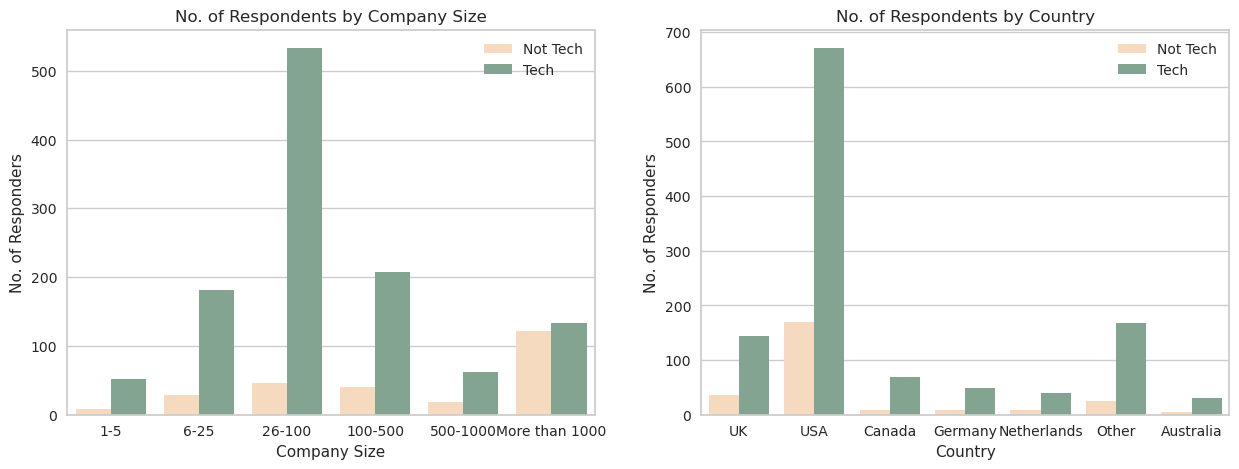

In [22]:
# First Chart
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x = imputed_df['Number of employees'], hue = imputed_df['Tech Company'], 
              order = ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'], 
              palette=["#FFD9B7", "#7EAA92"])

plt.title('No. of Respondents by Company Size')
plt.xlabel('Company Size')
plt.ylabel('No. of Responders')
plt.legend(['Not Tech', 'Tech'])

# Second Chart
plt.subplot(1, 2, 2)
sns.countplot(x = imputed_df['Country'], hue = imputed_df['Tech Company'], 
              palette=["#FFD9B7", "#7EAA92"])

plt.title('No. of Respondents by Country')
plt.ylabel('No. of Responders')
plt.legend(['Not Tech', 'Tech'])

### Gender by Country

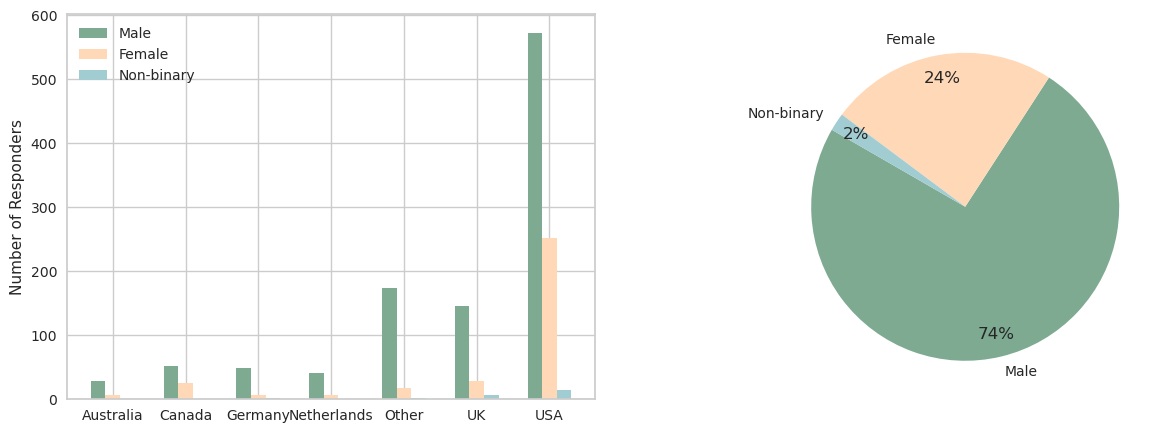

In [23]:
# plot data in grouped manner of bar type
countries_to_plot = imputed_df['Country'].value_counts().sort_index().keys()
x = np.arange(len(countries_to_plot))

male = imputed_df[imputed_df['Gender'] == 0]
female = imputed_df[imputed_df['Gender'] == 1]
non_binary = imputed_df[imputed_df['Gender'] == 2]

non_binary_value = non_binary[['Gender', 'Country']].value_counts().sort_index().tolist()
non_binary_value.insert(0, 0)

values = [male[['Gender', 'Country']].value_counts().sort_index().tolist(), 
          female[['Gender', 'Country']].value_counts().sort_index().tolist(),
          non_binary_value]

width = 0.2
colors = ["#7EAA92", "#FFD9B7" ,"#A1CCD1"]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(x-0.2, values[0], width, color=colors[0])
plt.bar(x, values[1], width, color=colors[1])
plt.bar(x+0.2, values[2], width, color=colors[2])

plt.xticks(x, countries_to_plot)
plt.ylabel("Number of Responders")
plt.legend(['Male', 'Female', 'Non-binary'])

# Pie chart

gender_labels = ['Male', 'Female', 'Non-binary']
values = imputed_df['Gender'].value_counts()
sizes = [values[0], values[1], values[2]]

plt.subplot(1, 2, 2)
plt.pie(sizes, colors=colors, labels=gender_labels, autopct='%1.f%%', startangle=150, pctdistance=0.85)

plt.show()

### Mental Health Disorder in Tech

In [24]:
imputed_df['MH Sharing Freinds/Family'].replace(to_replace='Not applicable to me (I do not have a mental illness)', value='No mental illness', inplace=True)

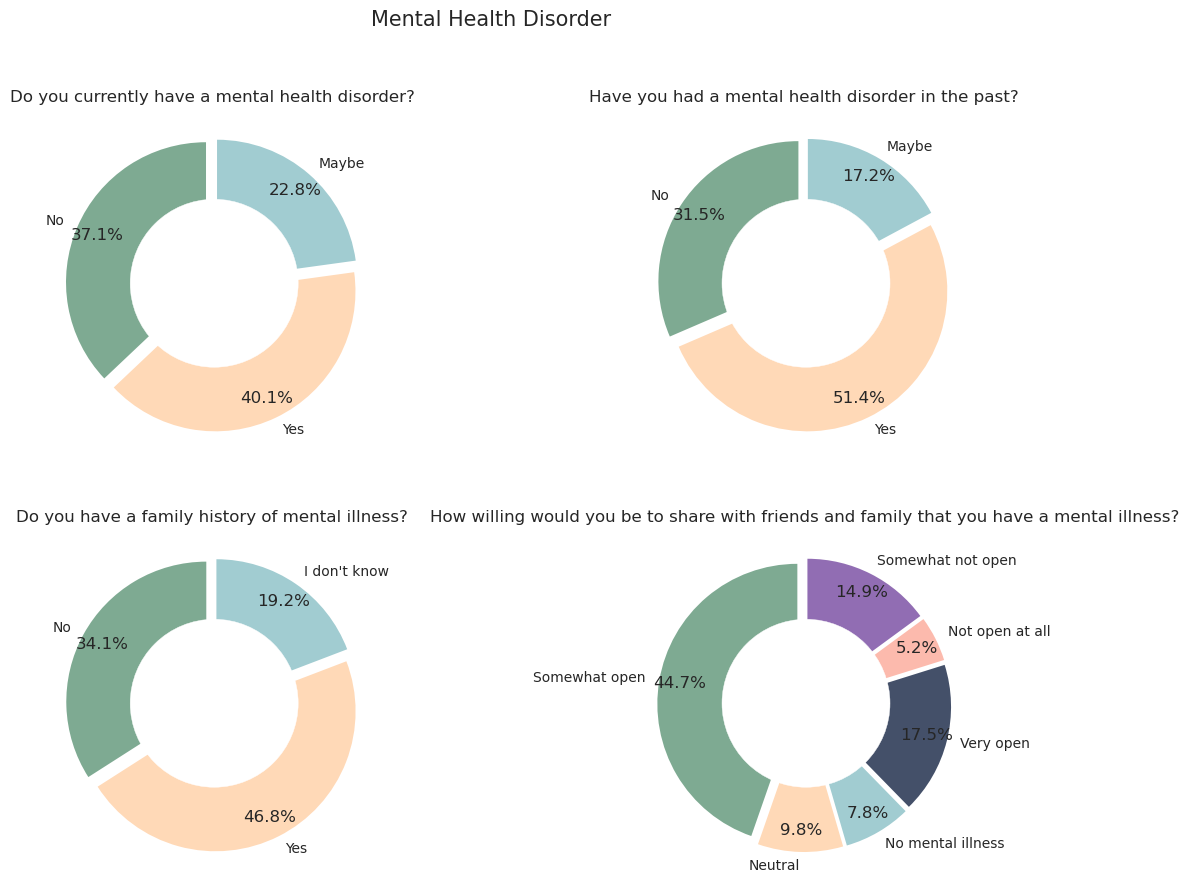

In [25]:
# First Pie: Current MH Disorder
labels = ['No', 'Yes', 'Maybe']

no_mhd = imputed_df[imputed_df['Current MH Disorder'] == "No"].shape[0]
yes_mhd = imputed_df[imputed_df['Current MH Disorder'] == "Yes"].shape[0]
maybe_mhd = imputed_df[imputed_df['Current MH Disorder'] == "Maybe"].shape[0]

sizes = [no_mhd, yes_mhd, maybe_mhd]
colors = ["#7EAA92", "#FFD9B7", "#A1CCD1"]
explode = (0.05,0.05,0.05)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
plt.suptitle('Mental Health Disorder', fontsize=15)

axs[0, 0].pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

## draw circle
centre_circle = plt.Circle((0.0125, 0.0125), 0.6, color='white')
axs[0, 0].add_artist(centre_circle)

axs[0, 0].set_title("Do you currently have a mental health disorder?")
 
# Second Pie: Past MH Disorder
labels_2 = ['No', 'Yes', 'Maybe']

no_mhd_2 = imputed_df[imputed_df['MH Disorder Past'] == "No"].shape[0]
yes_mhd_2 = imputed_df[imputed_df['MH Disorder Past'] == "Yes"].shape[0]
maybe_mhd_2 = imputed_df[imputed_df['MH Disorder Past'] == "Maybe"].shape[0]

sizes_2 = [no_mhd_2, yes_mhd_2, maybe_mhd_2]

axs[0, 1].pie(sizes_2, colors=colors, labels=labels_2, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

#draw circle
centre_circle = plt.Circle((0.0125, 0.0125), 0.6, color='white')
axs[0, 1].add_artist(centre_circle)

axs[0, 1].set_title("Have you had a mental health disorder in the past?")

# Third Pie Chart: MH Family History
labels_3 = ['No', 'Yes', "I don't know"]

no_mhd_3 = imputed_df[imputed_df['MH Family History'] == "No"].shape[0]
yes_mhd_3 = imputed_df[imputed_df['MH Family History'] == "Yes"].shape[0]
maybe_mhd_3 = imputed_df[imputed_df['MH Family History'] == "I don't know"].shape[0]

sizes_3 = [no_mhd_3, yes_mhd_3, maybe_mhd_3]

axs[1, 0].pie(sizes_3, colors=colors, labels=labels_3, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

#draw circle
centre_circle = plt.Circle((0.0125, 0.0125), 0.6, color='white')
axs[1, 0].add_artist(centre_circle)

axs[1, 0].set_title("Do you have a family history of mental illness?")

# Fourth Pie Chart: MH Sharing Freinds/Family
labels_4 = ['Somewhat open', 'Neutral', 'No mental illness', 
            'Very open', 'Not open at all', 'Somewhat not open']

som_open = imputed_df[imputed_df['MH Sharing Freinds/Family'] == "Somewhat open"].shape[0]
neutral = imputed_df[imputed_df['MH Sharing Freinds/Family'] == "Neutral"].shape[0]
no_mhd = imputed_df[imputed_df['MH Sharing Freinds/Family'] == "No mental illness"].shape[0]
open_ = imputed_df[imputed_df['MH Sharing Freinds/Family'] == "Very open"].shape[0]
no_open = imputed_df[imputed_df['MH Sharing Freinds/Family'] == "Not open at all"].shape[0]
som_no_open = imputed_df[imputed_df['MH Sharing Freinds/Family'] == "Somewhat not open"].shape[0]

explode_4 = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
colors_4 = ["#7EAA92", "#FFD9B7" ,"#A1CCD1", '#445069', '#FCBAAD', '#916DB3']

sizes_4 = [som_open, neutral, no_mhd, open_, no_open, som_no_open]

axs[1, 1].pie(sizes_4, colors=colors_4, labels=labels_4, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode_4)

#draw circle
centre_circle = plt.Circle((0.0125, 0.0125), 0.6, color='white')
axs[1, 1].add_artist(centre_circle)

axs[1, 1].set_title("How willing would you be to share with friends and family that you have a mental illness?")

plt.show()

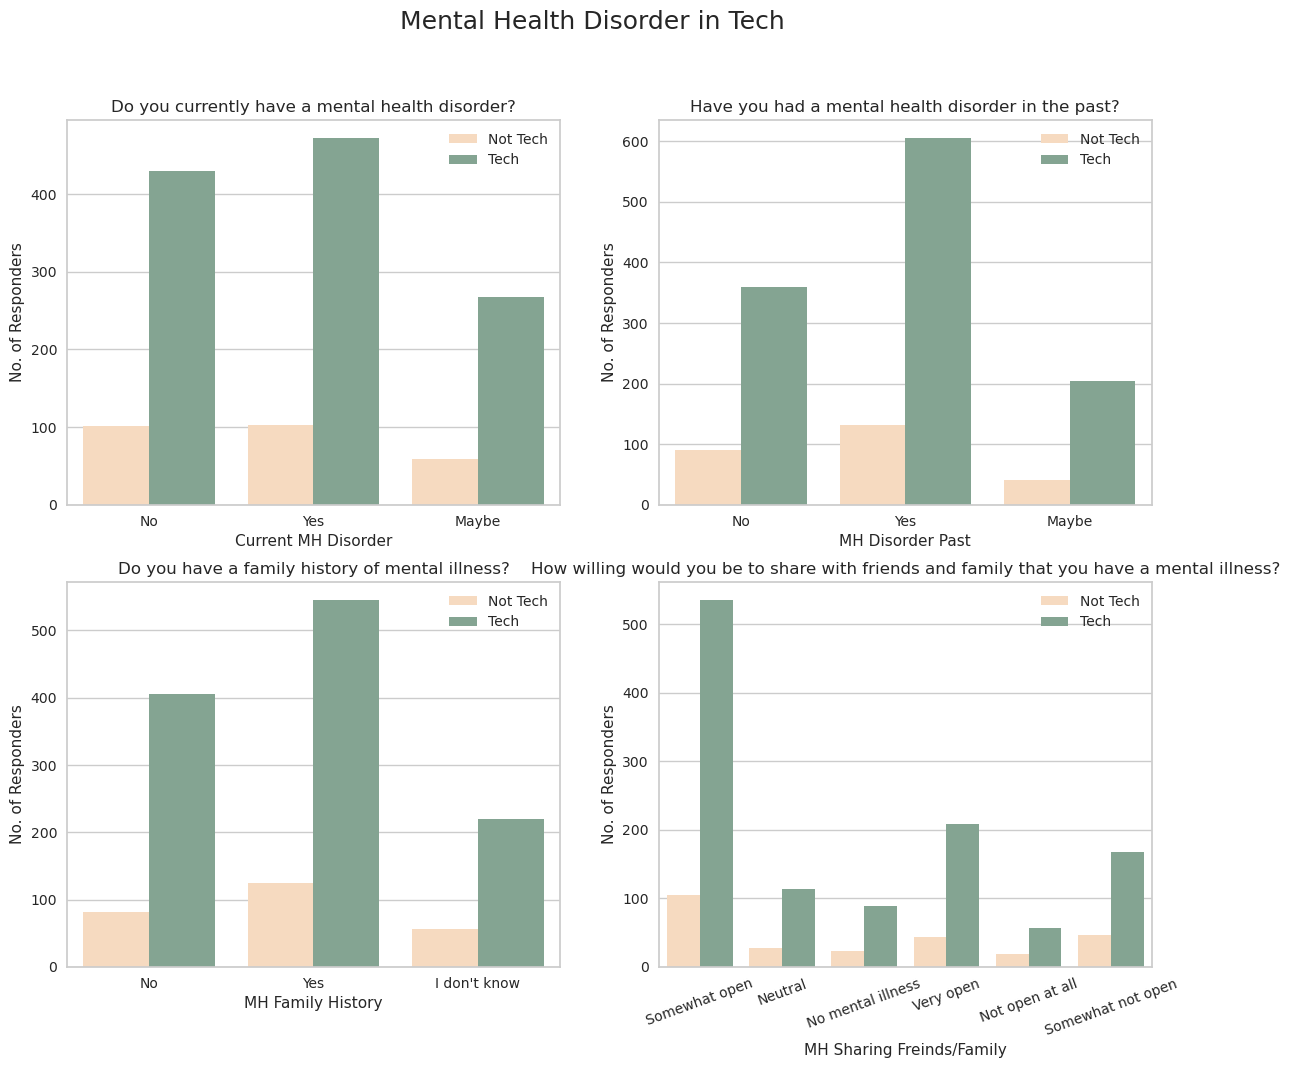

In [26]:
# First Chart: Current MH Disorder
plt.figure(figsize=(14, 11))
plt.suptitle('Mental Health Disorder in Tech', fontsize=18)
plt.subplot(2, 2, 1)
sns.countplot(x = imputed_df['Current MH Disorder'], hue = imputed_df['Tech Company'], 
              order = ['No', 'Yes', 'Maybe'], palette=["#FFD9B7", "#7EAA92"])

plt.title('Do you currently have a mental health disorder?')
plt.ylabel('No. of Responders')
plt.legend(['Not Tech', 'Tech'])

# Second Chart: Past MH Disorder
plt.subplot(2, 2, 2)
sns.countplot(x = imputed_df['MH Disorder Past'], hue = imputed_df['Tech Company'],
              order = ['No', 'Yes', 'Maybe'], palette=["#FFD9B7", "#7EAA92"])

plt.title('Have you had a mental health disorder in the past?')
plt.ylabel('No. of Responders')
plt.legend(['Not Tech', 'Tech'])

# Third Chart: MH Family History
plt.subplot(2, 2, 3)
sns.countplot(x = imputed_df['MH Family History'], hue = imputed_df['Tech Company'], 
              order = ['No', 'Yes', "I don't know"], palette=["#FFD9B7", "#7EAA92"])

plt.title('Do you have a family history of mental illness?')
plt.ylabel('No. of Responders')
plt.legend(['Not Tech', 'Tech'])

# Fourth Chart: MH Sharing Freinds/Family
plt.subplot(2, 2, 4)
sns.countplot(x = imputed_df['MH Sharing Freinds/Family'], hue = imputed_df['Tech Company'], 
              order = ['Somewhat open', 'Neutral', 'No mental illness', 
                       'Very open', 'Not open at all', 'Somewhat not open'], palette=["#FFD9B7", "#7EAA92"])

plt.title('How willing would you be to share with friends and family that you have a mental illness?')
plt.ylabel('No. of Responders')
plt.xticks(rotation=20)
plt.legend(['Not Tech', 'Tech'])

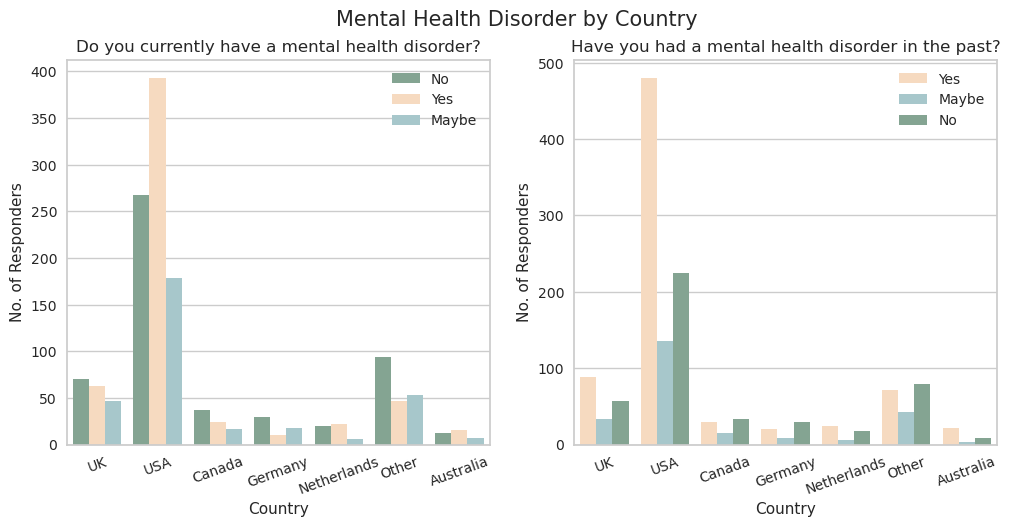

In [27]:
# First Chart: Current MH Disorder
plt.figure(figsize=(12, 5))
plt.suptitle('Mental Health Disorder by Country', fontsize=15)
plt.subplot(1, 2, 1)
sns.countplot(x = imputed_df['Country'], hue = imputed_df['Current MH Disorder'],
              palette=["#7EAA92", "#FFD9B7", "#A1CCD1"])

plt.title('Do you currently have a mental health disorder?')
plt.ylabel('No. of Responders')
plt.xticks(rotation=20)
plt.legend(['No', 'Yes', 'Maybe'])

# Second Chart: Past MH Disorder
plt.subplot(1, 2, 2)
sns.countplot(x = imputed_df['Country'], hue = imputed_df['MH Disorder Past'], 
              palette=["#FFD9B7", "#A1CCD1", "#7EAA92"])

plt.title('Have you had a mental health disorder in the past?')
plt.ylabel('No. of Responders')
plt.xticks(rotation=20)
plt.legend(['Yes', 'Maybe', 'No'])

### Mental Health Disorder and Career

In [28]:
to_replace = ["No, I don't think it would", "Yes, I think it would", 'No, it has not']
new_values = ["I don't think so", "I think yes", 'No']

for i in range(len(to_replace)):
    imputed_df['MH Bad Impact on Career'].replace(to_replace=to_replace[i], value=new_values[i], inplace=True)

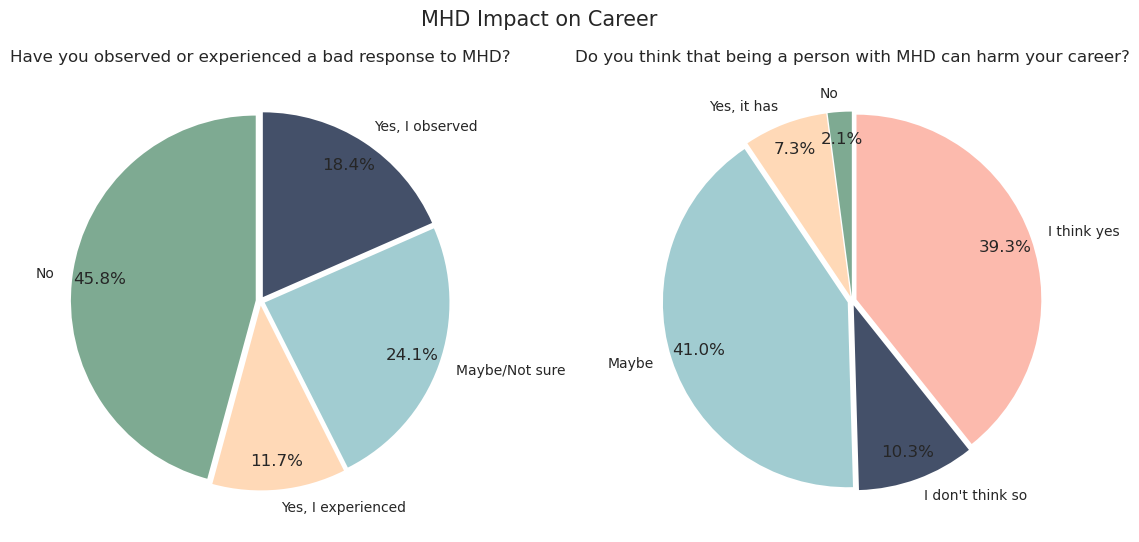

In [29]:
# First Pie: MH Bad Impact on Career
labels = ['No', 'Yes, it has', 'Maybe', "I don't think so", 'I think yes']

no_mhd = imputed_df[imputed_df['MH Bad Impact on Career'] == "No"].shape[0]
yes_mhd = imputed_df[imputed_df['MH Bad Impact on Career'] == "Yes, it has"].shape[0]
maybe_mhd = imputed_df[imputed_df['MH Bad Impact on Career'] == "Maybe"].shape[0]
think_no = imputed_df[imputed_df['MH Bad Impact on Career'] == "I don't think so"].shape[0]
think_yes = imputed_df[imputed_df['MH Bad Impact on Career'] == "I think yes"].shape[0]

sizes = [no_mhd, yes_mhd, maybe_mhd, think_no, think_yes]
colors = ["#7EAA92", "#FFD9B7", "#A1CCD1", '#445069', '#FCBAAD']
explode = (0.025, 0.025, 0.025, 0.025, 0.025)

plt.figure(figsize=(14, 6))
plt.suptitle('MHD Impact on Career', fontsize=15)
plt.subplot(1, 2, 2)

plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
plt.title("Do you think that being a person with MHD can harm your career?")
 
# Second Pie: MH Bad Response
labels_2 = ['No', 'Yes, I experienced', 'Maybe/Not sure', 'Yes, I observed']

no_mhd_2 = imputed_df[imputed_df['MH Bad Response'] == "No"].shape[0]
yes_mhd_2 = imputed_df[imputed_df['MH Bad Response'] == "Yes, I experienced"].shape[0]
maybe_mhd_2 = imputed_df[imputed_df['MH Bad Response'] == "Maybe/Not sure"].shape[0]
yes_obsv = imputed_df[imputed_df['MH Bad Response'] == "Yes, I observed"].shape[0]
explode_2 = (0.025, 0.025, 0.025, 0.025)

sizes_2 = [no_mhd_2, yes_mhd_2, maybe_mhd_2, yes_obsv]

plt.subplot(1, 2, 1)
plt.pie(sizes_2, colors=colors[:4], labels=labels_2, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode_2)

plt.title("Have you observed or experienced a bad response to MHD?")

plt.show()

### Interviews

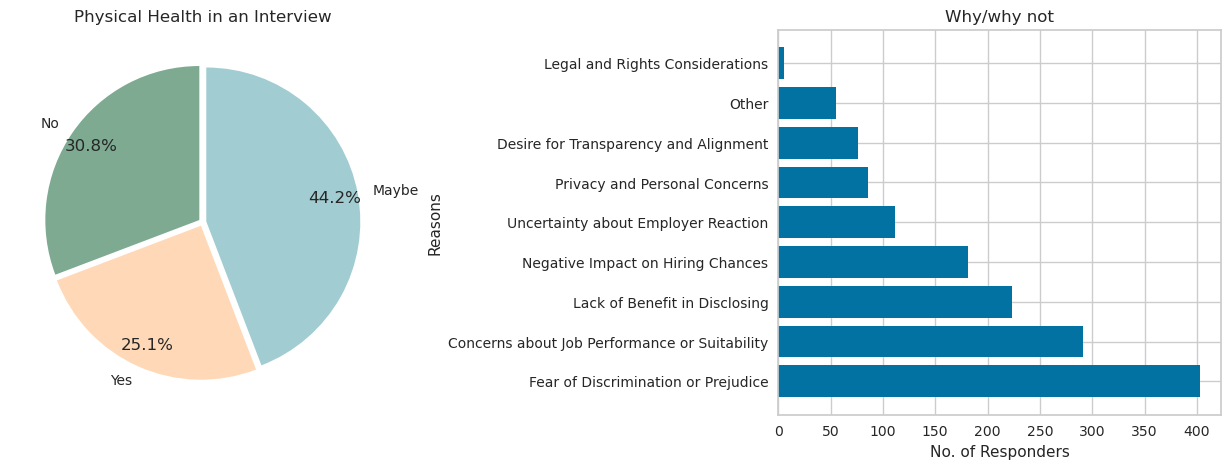

In [30]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 2)

y = imputed_df['Why/why not'].value_counts().keys()
x = imputed_df['Why/why not'].value_counts().tolist()

plt.barh(y, x)

plt.ylabel("Reasons")
plt.xlabel("No. of Responders")
plt.title("Why/why not")

# Second Pie: PH in Interview
labels = ['No', 'Yes', 'Maybe']

no_mhd = imputed_df[imputed_df['PH in Interview'] == "No"].shape[0]
yes_mhd = imputed_df[imputed_df['PH in Interview'] == "Yes"].shape[0]
maybe_mhd = imputed_df[imputed_df['PH in Interview'] == "Maybe"].shape[0]

sizes = [no_mhd, yes_mhd, maybe_mhd]
colors = ["#7EAA92", "#FFD9B7", "#A1CCD1"]
explode = (0.025, 0.025, 0.025)

plt.subplot(1, 2, 1)

plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
plt.title("Physical Health in an Interview")

plt.subplots_adjust(wspace=0.8)

plt.show()

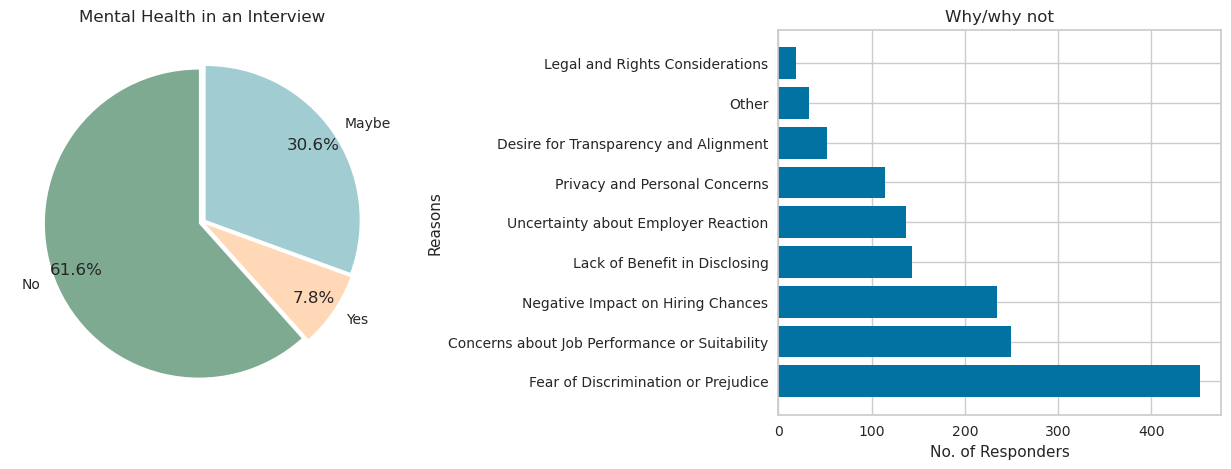

In [31]:
# First Chart

no_mhd_2 = imputed_df[imputed_df['MH in Interview'] == "No"].shape[0]
yes_mhd_2 = imputed_df[imputed_df['MH in Interview'] == "Yes"].shape[0]
maybe_mhd_2 = imputed_df[imputed_df['MH in Interview'] == "Maybe"].shape[0]

sizes_2 = [no_mhd_2, yes_mhd_2, maybe_mhd_2]

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.pie(sizes_2, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

plt.title("Mental Health in an Interview")

# Second Chart
plt.subplot(1, 2, 2)

y_1 = imputed_df['Why/why not (1)'].value_counts().keys()
x_1 = imputed_df['Why/why not (1)'].value_counts().tolist()

plt.barh(y_1, x_1)

plt.title('Why/why not')
plt.ylabel('Reasons')
plt.xlabel("No. of Responders")

plt.subplots_adjust(wspace=0.8)

plt.show()

### Mental Health Discussion in the Current Workplace

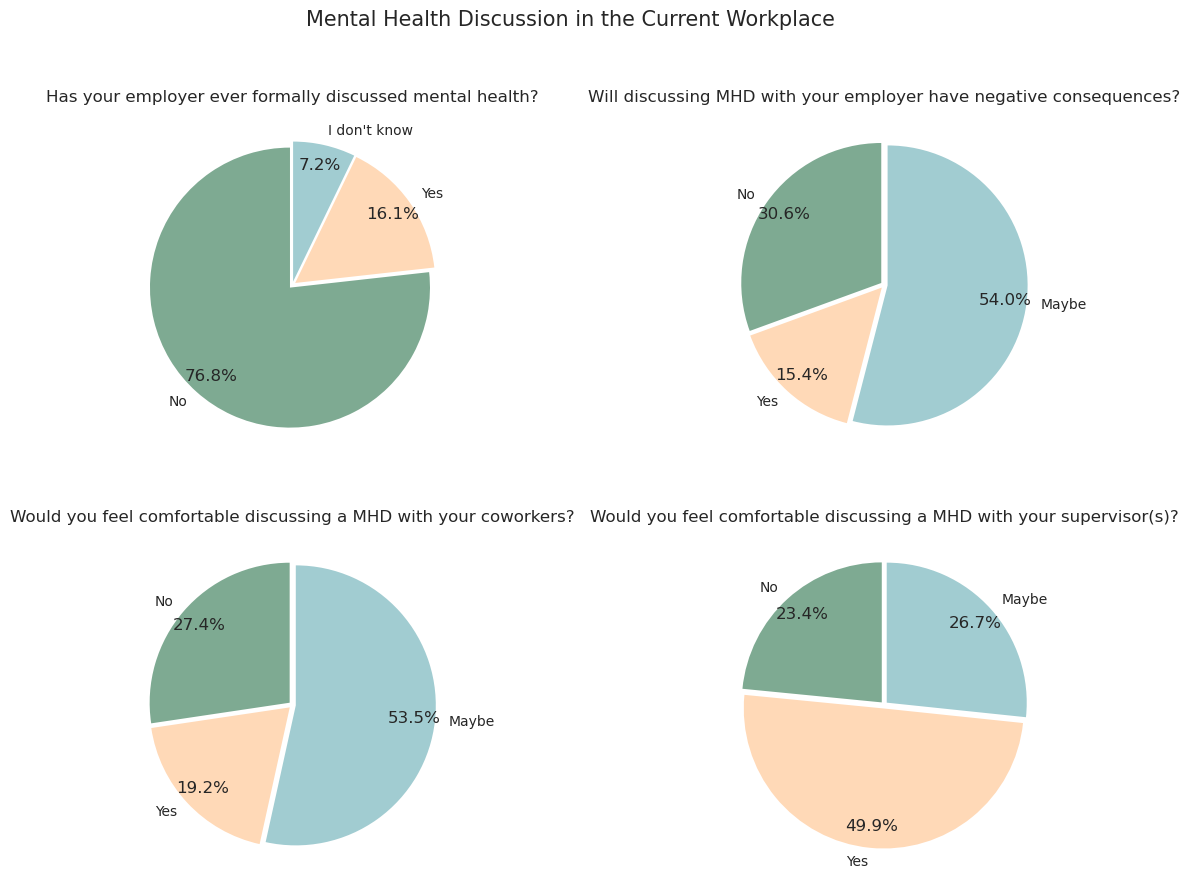

In [32]:
# First Pie: MH Discussion
labels = ['No', 'Yes', "I don't know"]

no_mhd = imputed_df[imputed_df['MH Discussion'] == "No"].shape[0]
yes_mhd = imputed_df[imputed_df['MH Discussion'] == "Yes"].shape[0]
dont_know = imputed_df[imputed_df['MH Discussion'] == "I don't know"].shape[0]

sizes = [no_mhd, yes_mhd, dont_know]
colors = ["#7EAA92", "#FFD9B7", "#A1CCD1"]
explode = (0.025, 0.025, 0.025)

plt.figure(figsize=(14, 10))
plt.suptitle('Mental Health Discussion in the Current Workplace', fontsize=15)
plt.subplot(2, 2, 1)

plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
plt.title("Has your employer ever formally discussed mental health?")

# Second Pie: MH Discuission Neg Impact 
labels_2 = ['No', 'Yes', 'Maybe']

no_mhd_2 = imputed_df[imputed_df['MH Discuission Neg Impact'] == "No"].shape[0]
yes_mhd_2 = imputed_df[imputed_df['MH Discuission Neg Impact'] == "Yes"].shape[0]
maybe_mhd_2 = imputed_df[imputed_df['MH Discuission Neg Impact'] == "Maybe"].shape[0]

sizes_2 = [no_mhd_2, yes_mhd_2, maybe_mhd_2]

plt.subplot(2, 2, 2)
plt.pie(sizes_2, colors=colors, labels=labels_2, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

plt.title("Will discussing MHD with your employer have negative consequences?")

# Third Pie: MH Discuission Coworkers 

no_mhd_3 = imputed_df[imputed_df['MH Discuission Coworkers'] == "No"].shape[0]
yes_mhd_3 = imputed_df[imputed_df['MH Discuission Coworkers'] == "Yes"].shape[0]
maybe_mhd_3 = imputed_df[imputed_df['MH Discuission Coworkers'] == "Maybe"].shape[0]

sizes_3 = [no_mhd_3, yes_mhd_3, maybe_mhd_3]

plt.subplot(2, 2, 3)
plt.pie(sizes_3, colors=colors, labels=labels_2, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

plt.title("Would you feel comfortable discussing a MHD with your coworkers?")

# Fourth Pie: MH Discuission Supervisor(s) 

no_mhd_4 = imputed_df[imputed_df['MH Discuission Supervisor(s)'] == "No"].shape[0]
yes_mhd_4 = imputed_df[imputed_df['MH Discuission Supervisor(s)'] == "Yes"].shape[0]
maybe_mhd_4 = imputed_df[imputed_df['MH Discuission Supervisor(s)'] == "Maybe"].shape[0]

sizes_4 = [no_mhd_4, yes_mhd_4, maybe_mhd_4]

plt.subplot(2, 2, 4)
plt.pie(sizes_4, colors=colors, labels=labels_2, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

plt.title("Would you feel comfortable discussing a MHD with your supervisor(s)?")

plt.show()

### Mental Health Discussion in the Previous Workplace

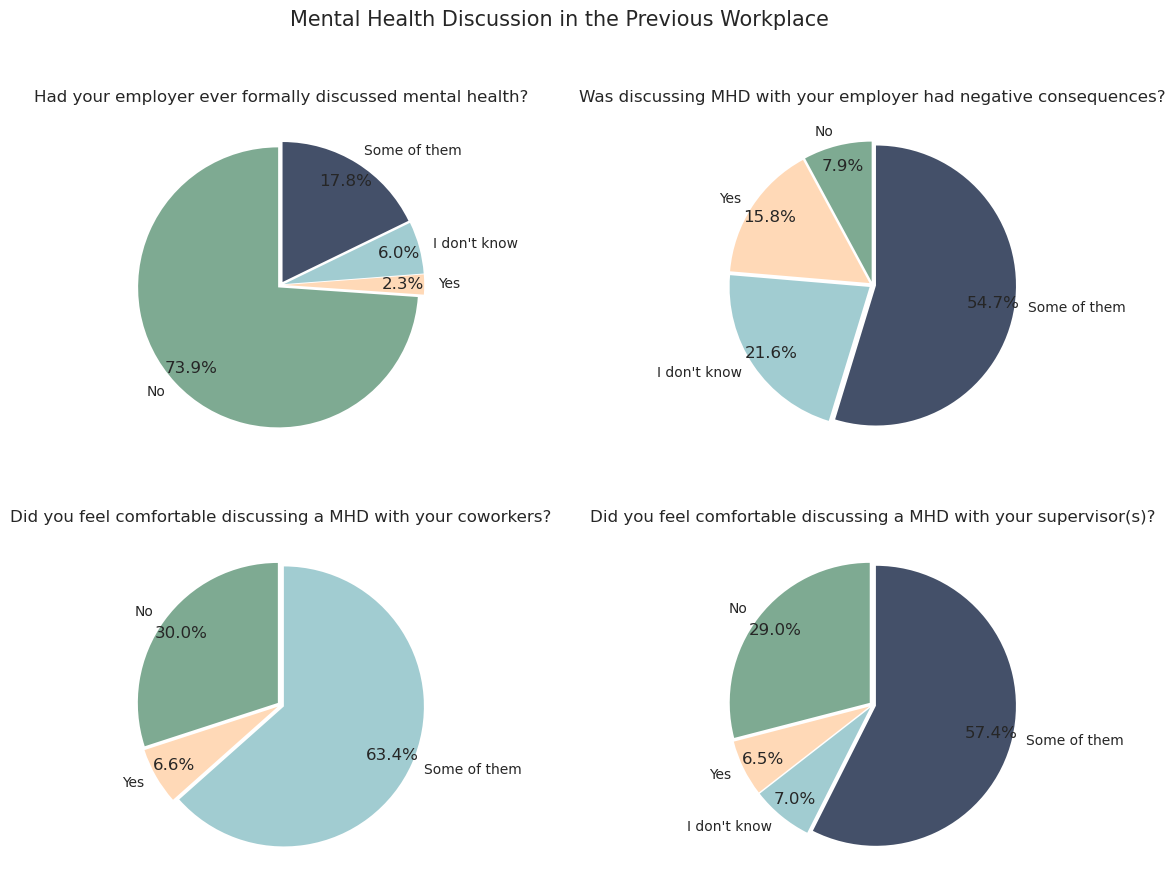

In [33]:
# First Pie: Prev MH Discussion
labels = ['No', 'Yes', "I don't know", "Some of them"]

no_mhd = imputed_df[imputed_df['Prev MH Discussion'] == "None did"].shape[0]
yes_mhd = imputed_df[imputed_df['Prev MH Discussion'] == "Yes, they all did"].shape[0]
dont_know = imputed_df[imputed_df['Prev MH Discussion'] == "I don't know"].shape[0]
some = imputed_df[imputed_df['Prev MH Discussion'] == "Some did"].shape[0]

sizes = [no_mhd, yes_mhd, dont_know, some]
colors = ["#7EAA92", "#FFD9B7", "#A1CCD1", '#445069']
explode = (0.025, 0.025, 0.025, 0.025)

plt.figure(figsize=(14, 10))
plt.suptitle('Mental Health Discussion in the Previous Workplace', fontsize=15)
plt.subplot(2, 2, 1)

plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
plt.title("Had your employer ever formally discussed mental health?")

# Second Pie: Prev MH Discuission Neg Impact 

no_mhd_2 = imputed_df[imputed_df['Prev MH Discuission Neg Impact'] == "None of them"].shape[0]
yes_mhd_2 = imputed_df[imputed_df['Prev MH Discuission Neg Impact'] == "Yes, all of them"].shape[0]
dont_know = imputed_df[imputed_df['Prev MH Discuission Neg Impact'] == "I don't know"].shape[0]
some = imputed_df[imputed_df['Prev MH Discuission Neg Impact'] == "Some of them"].shape[0]

sizes_2 = [no_mhd_2, yes_mhd_2, dont_know, some]

plt.subplot(2, 2, 2)
plt.pie(sizes_2, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

plt.title("Was discussing MHD with your employer had negative consequences?")

# Third Pie: Prev MH Discuission Coworkers 

labels_3 = ['No', 'Yes', "Some of them"]

no_mhd_3 = imputed_df[imputed_df['Prev MH Discuission Coworkers'] == "No, at none of my previous employers"].shape[0]
yes_mhd_3 = imputed_df[imputed_df['Prev MH Discuission Coworkers'] == "Yes, at all of my previous employers"].shape[0]
some = imputed_df[imputed_df['Prev MH Discuission Coworkers'] == "Some of my previous employers"].shape[0]

sizes_3 = [no_mhd_3, yes_mhd_3, some]
explode_3 = (0.025, 0.025, 0.025)

plt.subplot(2, 2, 3)
plt.pie(sizes_3, colors=colors[:3], labels=labels_3, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode_3)

plt.title("Did you feel comfortable discussing a MHD with your coworkers?")

# Fourth Pie: Prev MH Discuission Supervisor(s) 

no_mhd_4 = imputed_df[imputed_df['Prev MH Discuission Supervisor(s)'] == "No, at none of my previous employers"].shape[0]
yes_mhd_4 = imputed_df[imputed_df['Prev MH Discuission Supervisor(s)'] == "Yes, at all of my previous employers"].shape[0]
dont_know = imputed_df[imputed_df['Prev MH Discuission Supervisor(s)'] == "I don't know"].shape[0]
some = imputed_df[imputed_df['Prev MH Discuission Supervisor(s)'] == "Some of my previous employers"].shape[0]

sizes_4 = [no_mhd_4, yes_mhd_4, dont_know, some]

plt.subplot(2, 2, 4)
plt.pie(sizes_4, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

plt.title("Did you feel comfortable discussing a MHD with your supervisor(s)?")

plt.show()

### MH Coverage Awareness / Resources

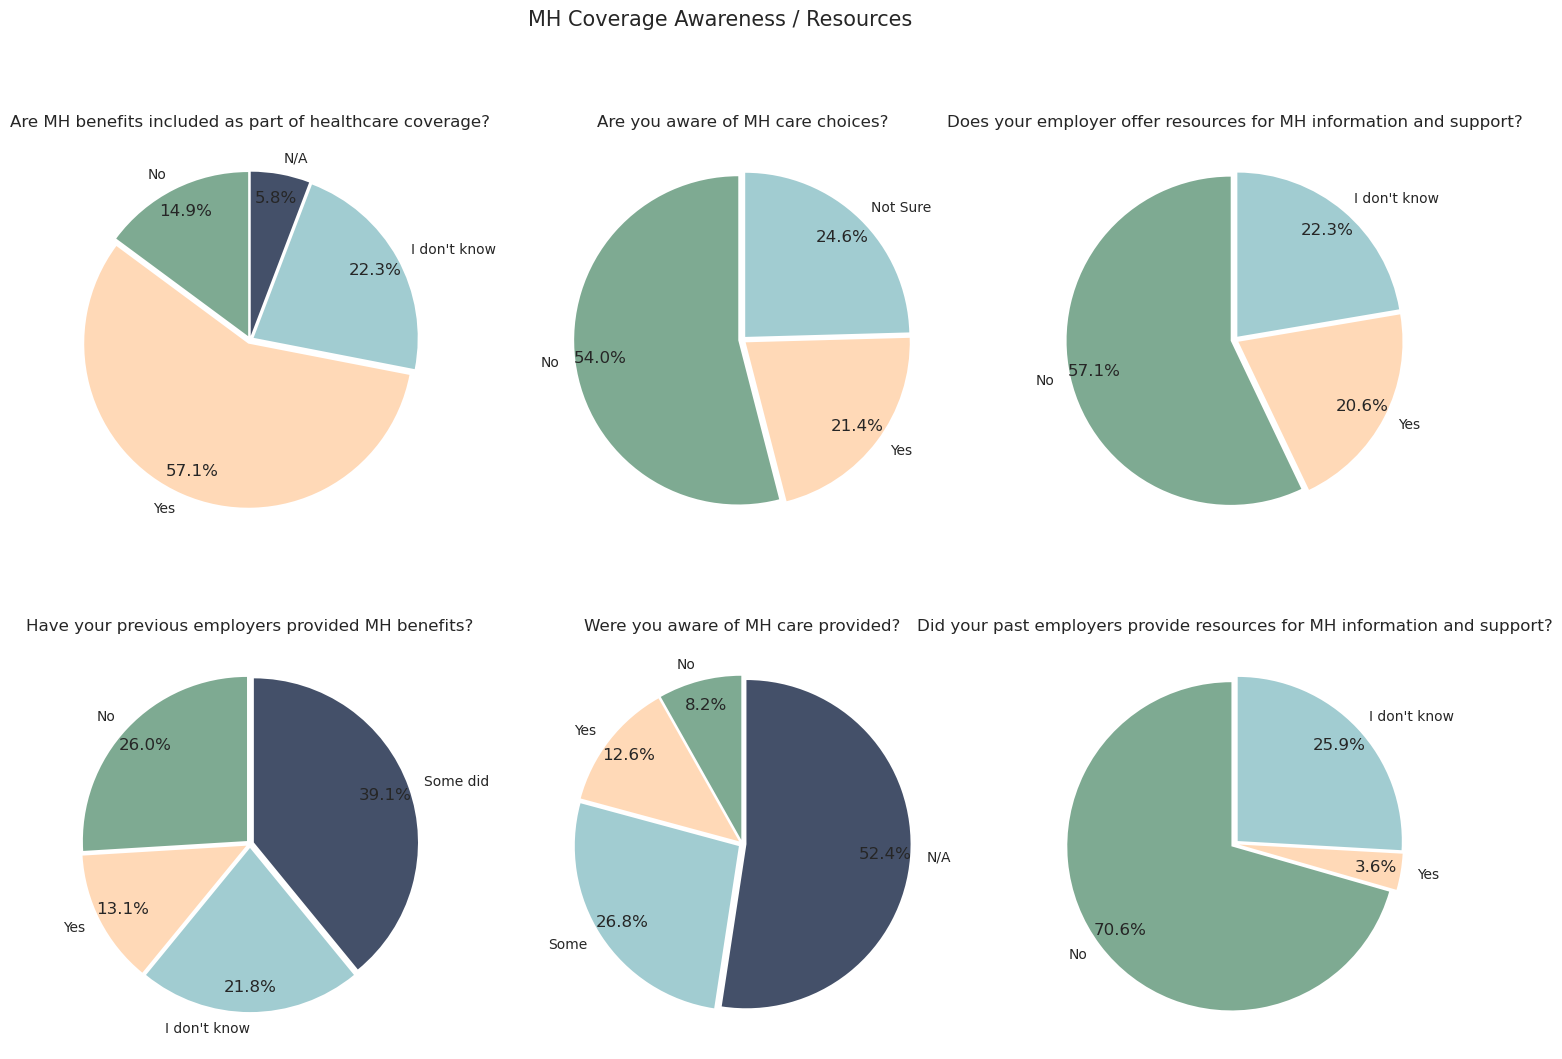

In [34]:
# First Pie: Prev MH Discussion
labels = ['No', 'Yes', "I don't know", "N/A"]

no_mhd = imputed_df[imputed_df['MH Coverage'] == "No"].shape[0]
yes_mhd = imputed_df[imputed_df['MH Coverage'] == "Yes"].shape[0]
dont_know = imputed_df[imputed_df['MH Coverage'] == "I don't know"].shape[0]
n_a = imputed_df[imputed_df['MH Coverage'] == "Not eligible for coverage / N/A"].shape[0]

sizes = [no_mhd, yes_mhd, dont_know, n_a]
colors = ["#7EAA92", "#FFD9B7", "#A1CCD1", '#445069']
explode = (0.025, 0.025, 0.025, 0.025)

plt.figure(figsize=(18, 12))
plt.suptitle('MH Coverage Awareness / Resources', fontsize=15)
plt.subplot(2, 3, 1)

plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
plt.title("Are MH benefits included as part of healthcare coverage?")

# Second Pie: MH Coverage Awareness 

labels_2 = ['No', 'Yes', 'Not Sure']

no_mhd_2 = imputed_df[imputed_df['MH Coverage Awareness'] == "No"].shape[0]
yes_mhd_2 = imputed_df[imputed_df['MH Coverage Awareness'] == "Yes"].shape[0]
dont_know = imputed_df[imputed_df['MH Coverage Awareness'] == "I am not sure"].shape[0]

sizes_2 = [no_mhd_2, yes_mhd_2, dont_know]
explode_2 = (0.025, 0.025, 0.025)

plt.subplot(2, 3, 2)
plt.pie(sizes_2, colors=colors[:3], labels=labels_2, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode_2)

plt.title("Are you aware of MH care choices?")

# Third Pie: MH Resources Provided 

no_mhd_3 = imputed_df[imputed_df['MH Resources Provided'] == "No"].shape[0]
yes_mhd_3 = imputed_df[imputed_df['MH Resources Provided'] == "Yes"].shape[0]
dont_know = imputed_df[imputed_df['MH Resources Provided'] == "I don't know"].shape[0]

sizes_3 = [no_mhd_3, yes_mhd_3, dont_know]

plt.subplot(2, 3, 3)
plt.pie(sizes_3, colors=colors[:3], labels=labels[:3], autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode_2)

plt.title("Does your employer offer resources for MH information and support?")

# Fourth Pie: Prev MH Benefits 
labels_4 = ['No', 'Yes', "I don't know", 'Some did']

no_mhd = imputed_df[imputed_df['Prev MH Benefits'] == "No, none did"].shape[0]
yes_mhd = imputed_df[imputed_df['Prev MH Benefits'] == "Yes, they all did"].shape[0]
dont_know = imputed_df[imputed_df['Prev MH Benefits'] == "I don't know"].shape[0]
some = imputed_df[imputed_df['Prev MH Benefits'] == "Some did"].shape[0]

sizes = [no_mhd, yes_mhd, dont_know, some]

plt.subplot(2, 3, 4)
plt.pie(sizes, colors=colors, labels=labels_4, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
plt.title("Have your previous employers provided MH benefits?")

# Fifth Pie: Prev MH Coverage Awareness 
labels_5 = ['No', 'Yes', 'Some', 'N/A']

no_mhd_5 = imputed_df[imputed_df['MH Awarness Prev'] == "No, I only became aware later"].shape[0]
yes_mhd_5 = imputed_df[imputed_df['MH Awarness Prev'] == "Yes, I was aware of all of them"].shape[0]
some = imputed_df[imputed_df['MH Awarness Prev'] == "I was aware of some"].shape[0]
n_a = imputed_df[imputed_df['MH Awarness Prev'] == "N/A (not currently aware)"].shape[0]


sizes_5 = [no_mhd_5, yes_mhd_5, some, n_a]

plt.subplot(2, 3, 5)
plt.pie(sizes_5, colors=colors, labels=labels_5, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

plt.title("Were you aware of MH care provided?")

# Sixth Pie: Prev MH Resources Provided 
labels_6 = ['No', 'Yes', 'Some did']

no_mhd_6 = imputed_df[imputed_df['Prev MH Resources Provided'] == "None did"].shape[0]
yes_mhd_6 = imputed_df[imputed_df['Prev MH Resources Provided'] == "Yes, they all did"].shape[0]
dont_know = imputed_df[imputed_df['Prev MH Resources Provided'] == "Some did"].shape[0]

sizes_6 = [no_mhd_6, yes_mhd_6, dont_know]
explode_3 = (0.025, 0.025, 0.025)

plt.subplot(2, 3, 6)
plt.pie(sizes_6, colors=colors[:3], labels=labels[:3], autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode_2)

plt.title("Did your past employers provide resources for MH information and support?")

plt.show()

# Step 2: Dimensionality Reduction and Clustering

### Principal Component Analysis (PCA)

In [35]:
n_components = 32 # 33 principal components gives 85%

pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)


# the explained cumulative variance
var_exp = pca.explained_variance_ratio_ * 100
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

[ 8.74788216 14.83787079 20.26659397 25.47993099 29.66639417 33.61658674
 37.09426338 40.18295057 42.99419896 45.58437819 48.03542021 50.35591433
 52.6158088  54.81594624 56.90268553 58.94597224 60.96266123 62.87329978
 64.73802259 66.51626588 68.25877864 69.97851116 71.63680643 73.23998823
 74.83488489 76.36170402 77.86814411 79.33919321 80.78848017 82.19835906
 83.56468095 84.85542449]


In [36]:
principal_components.shape

(1433, 32)

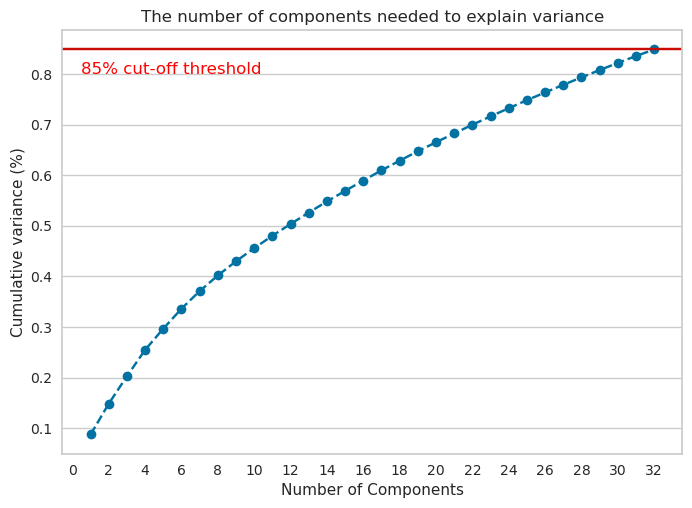

In [37]:
fig, ax = plt.subplots()
x = np.arange(1, n_components + 1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.plot(x, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, n_components + 1, step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.85, color='r', linestyle='-')
plt.text(0.5, 0.80, '85% cut-off threshold', color='red', fontsize=12)

ax.grid(axis='x')
plt.show()

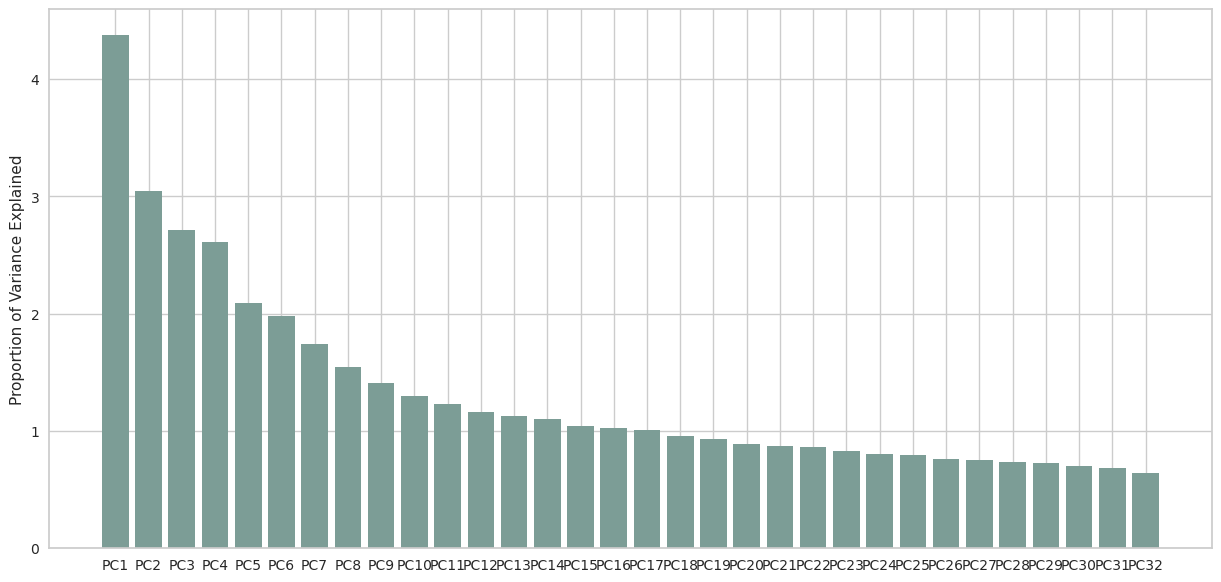

In [38]:
var = pca.explained_variance_
labels = [f'PC{i}' for i in list(range(1, n_components + 1))]

plt.figure(figsize=(15,7))
plt.bar(labels,var, color="#7C9D96")
plt.ylabel('Proportion of Variance Explained')
plt.show()

### Elbow

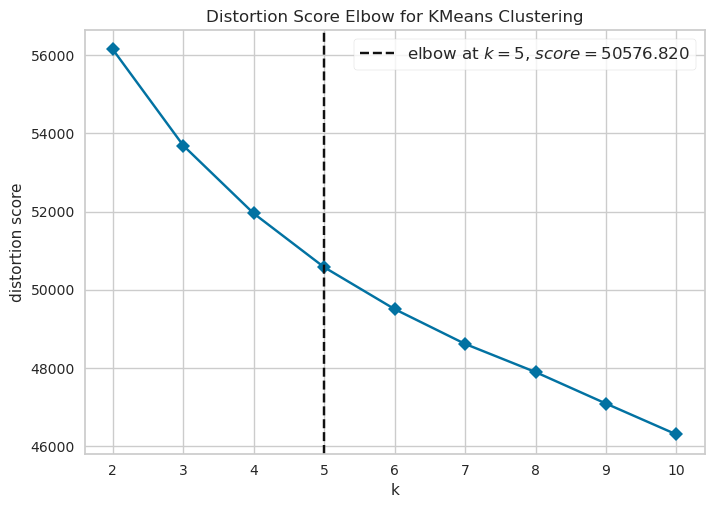

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
# create a k-Means model an Elbow-Visualizer
model = KMeans(n_init=10, init="k-means++", max_iter=200)
visualizer = KElbowVisualizer(model, timings=False) 
# fit the visualizer and show the plot
visualizer.fit(principal_components)
visualizer.show()

### Kmeans

In [40]:
# clustering
kmeans = KMeans(n_clusters=5, random_state=0, n_init='auto',init='k-means++', max_iter=200)
clustering = kmeans.fit_predict(principal_components)


# extract centroids of clusters into a dataframe
centers = kmeans.cluster_centers_

# extract cluster labels
labels = kmeans.labels_ 
scaled_df["Labels"] = labels
labeled_df["Labels"] = labels

In [41]:
# Analyzing cluster characteristics
cluster_characteristics = []
for i in range(5):
    cluster_data = principal_components[labels == i]
    cluster_size = len(cluster_data)
    cluster_center = centers[i]
    avg_distance = np.mean(np.linalg.norm(cluster_data - cluster_center, axis=1))
    cluster_characteristics.append({
        "Cluster": i,
        "Size": cluster_size,
        "Avg Distance": avg_distance,
    })

cluster_characteristics

[{'Cluster': 0, 'Size': 215, 'Avg Distance': 6.120565865892086},
 {'Cluster': 1, 'Size': 279, 'Avg Distance': 5.32765060293721},
 {'Cluster': 2, 'Size': 224, 'Avg Distance': 6.427154966542226},
 {'Cluster': 3, 'Size': 400, 'Avg Distance': 5.81618263219566},
 {'Cluster': 4, 'Size': 315, 'Avg Distance': 5.899330582913553}]

In [42]:
# Inertia
inertia_score = kmeans.inertia_
print("Inertia:", inertia_score)

# Silhouette Score

silhouette_avg = silhouette_score(principal_components, labels)
print("Silhouette Avg:", silhouette_avg)

Inertia: 50689.4983592792
Silhouette Avg: 0.06103069824816965


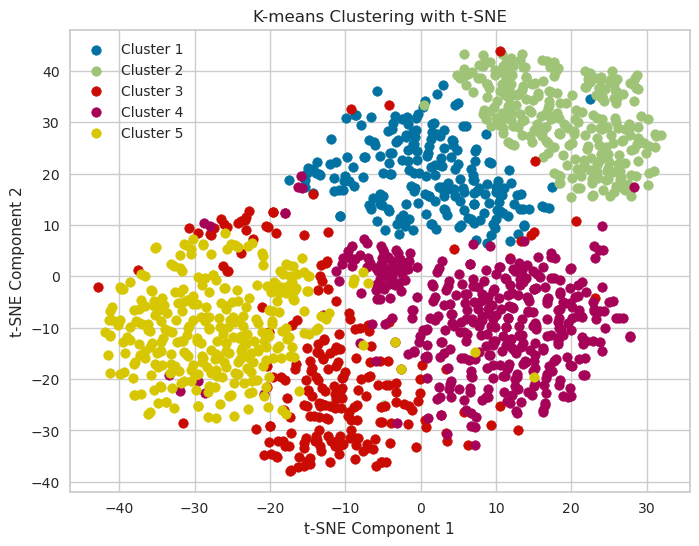

In [43]:
# Visualization of kmeans with TSNE

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(scaled_df)

plt.figure(figsize=(8, 6))
for i in range(5):
    plt.scatter(projections[labels == i][:, 0], projections[labels == i][:, 1], label=f'Cluster {i + 1}')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-means Clustering with t-SNE')
plt.legend()
plt.show()

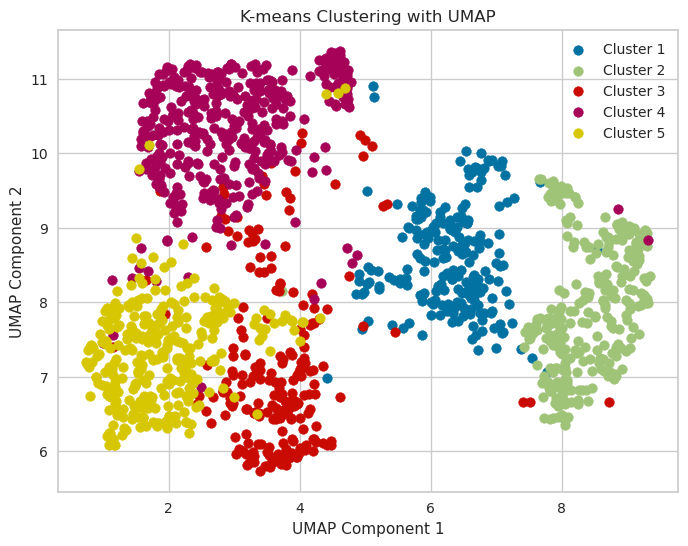

In [44]:
# Visualization of kmeans with UMAP

umap = UMAP(n_components=2, random_state=0, init='random')
umap_projections = umap.fit_transform(scaled_df)

plt.figure(figsize=(8, 6))
for i in range(5):
    plt.scatter(umap_projections[labels == i][:, 0], umap_projections[labels == i][:, 1], label=f'Cluster {i + 1}')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('K-means Clustering with UMAP')
plt.legend()
plt.show()

## PCA as Feature Selection

In [45]:
top_components = pca.components_[:n_components]
# Calculate the absolute values of loadings and sort features by importance
feature_importance = np.abs(top_components).sum(axis=0)
sorted_feature_indices = np.argsort(feature_importance)[::-1]
# Select the top features
selected_feature_indices = sorted_feature_indices[:n_components]
selected_features = scaled_df.columns[selected_feature_indices]
selected_features

Index(['Age', 'MH in Interview', 'Gender', 'Tech Company',
       'MH Coworker Reveal Neg Impact', 'Number of employees',
       'PH in Interview', 'Medical Leave', 'MH Bad Response', 'MH Discussion',
       'PH Discuission Neg Impact', 'MH Family History', 'Remote',
       'MH Awarness Prev', 'MH Coverage Awareness',
       'MH Sharing Freinds/Family', 'MH Discuission Coworkers',
       'Prev PH Discuission Neg Impact', 'Work Position', 'MH Anonimity',
       'MH NOT Effective Treatment', 'MH Discuission Supervisor(s)',
       'MH Discuission Neg Impact', 'Prev MH as PH',
       'Prev MH Coworker Reveal Neg Impact', 'MH Effective Treatment',
       'Prev MH Anonimity', 'MH as PH', 'Prev MH Discuission Neg Impact',
       'Why/why not (1)', 'MH Bad Impact on Career', 'Prev MH Benefits'],
      dtype='object')

In [46]:
reduced_labeled_df = labeled_df[selected_features]
reduced_labeled_df['Cluster'] = labels

/tmp/ipykernel_20/746864693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_labeled_df['Cluster'] = labels


<Axes: >

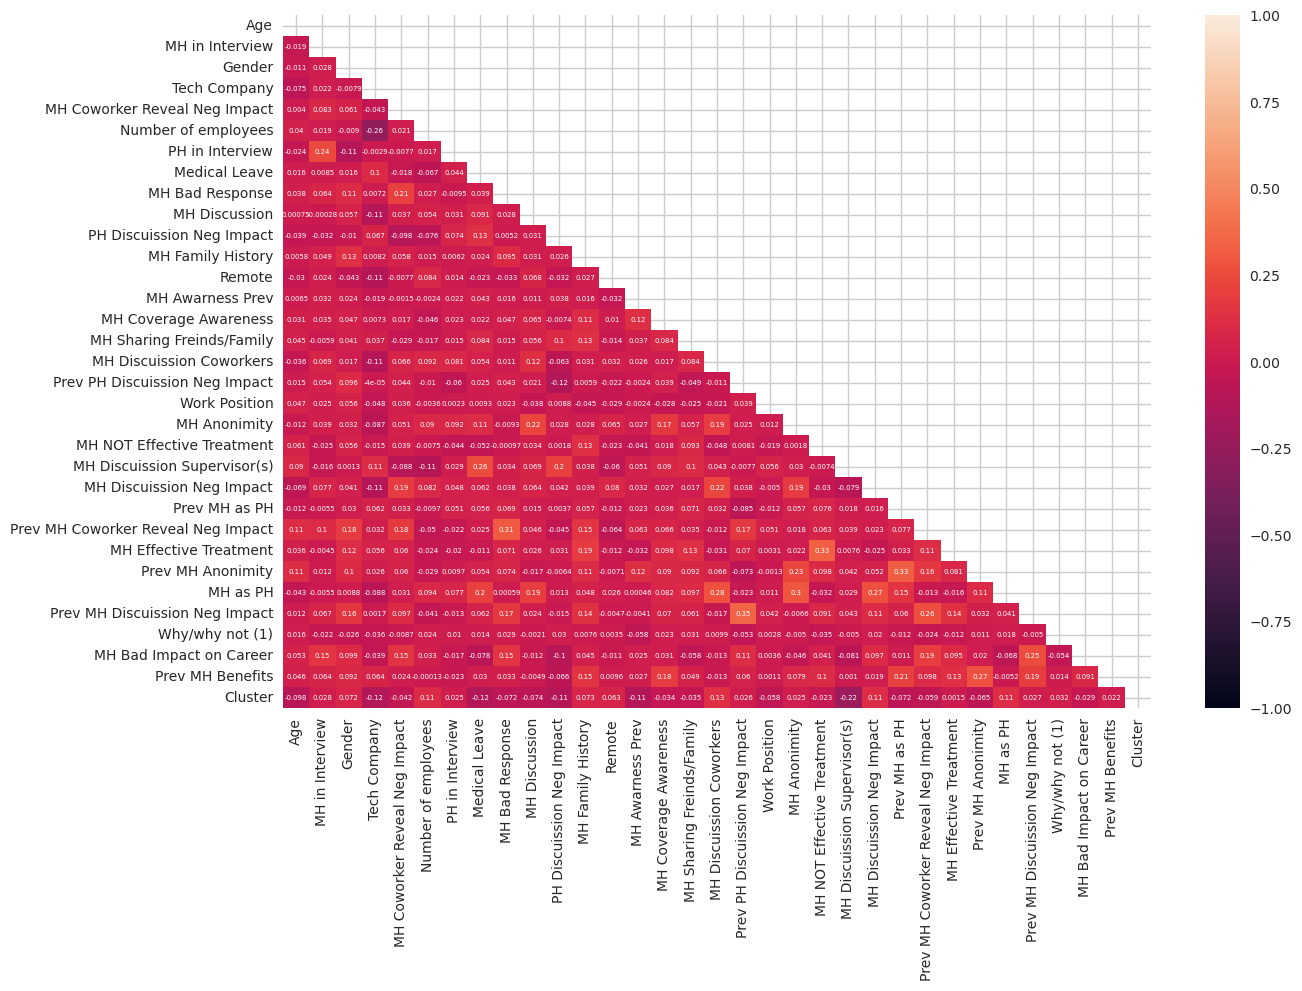

In [47]:
corr_2 = reduced_labeled_df.corr()
plt.figure(figsize=(14, 9))
mask = np.triu(np.ones_like(corr_2, dtype=bool))

sns.heatmap(corr_2, vmin=-1, vmax=1, mask=mask, annot=True, annot_kws={'size': 5})

# Step 3: Feature Importance

## Variance Threshold

In [48]:
selector_ = VarianceThreshold(threshold=0.5)
selector_.fit(labeled_df)
cols_ind = selector_.get_support(indices=True)
cols_names = labeled_df.columns
selected_cols_names = [cols_names[i] for i in cols_ind]
selected_cols_names

['Number of employees',
 'MH Coverage',
 'MH Anonimity',
 'Medical Leave',
 'MH Discuission Neg Impact',
 'MH Discuission Coworkers',
 'MH Discuission Supervisor(s)',
 'MH as PH',
 'Prev MH Benefits',
 'MH Awarness Prev',
 'Prev MH Anonimity',
 'Prev MH Discuission Neg Impact',
 'Prev MH Discuission Supervisor(s)',
 'Prev MH as PH',
 'PH in Interview',
 'Why/why not',
 'Why/why not (1)',
 'MH Bad Impact on Career',
 'MH Neg View of Coworkers',
 'MH Sharing Freinds/Family',
 'MH Bad Response',
 'MH Family History',
 'MH Disorder Past',
 'Current MH Disorder',
 'MH Effective Treatment',
 'MH NOT Effective Treatment',
 'Age',
 'Country',
 'US State',
 'Work Country',
 'Work US State',
 'Work Position',
 'Remote',
 'Labels']

## Correlation

In [49]:
corr = labeled_df[selected_cols_names].corr()
corr.shape

(34, 34)

<Axes: >

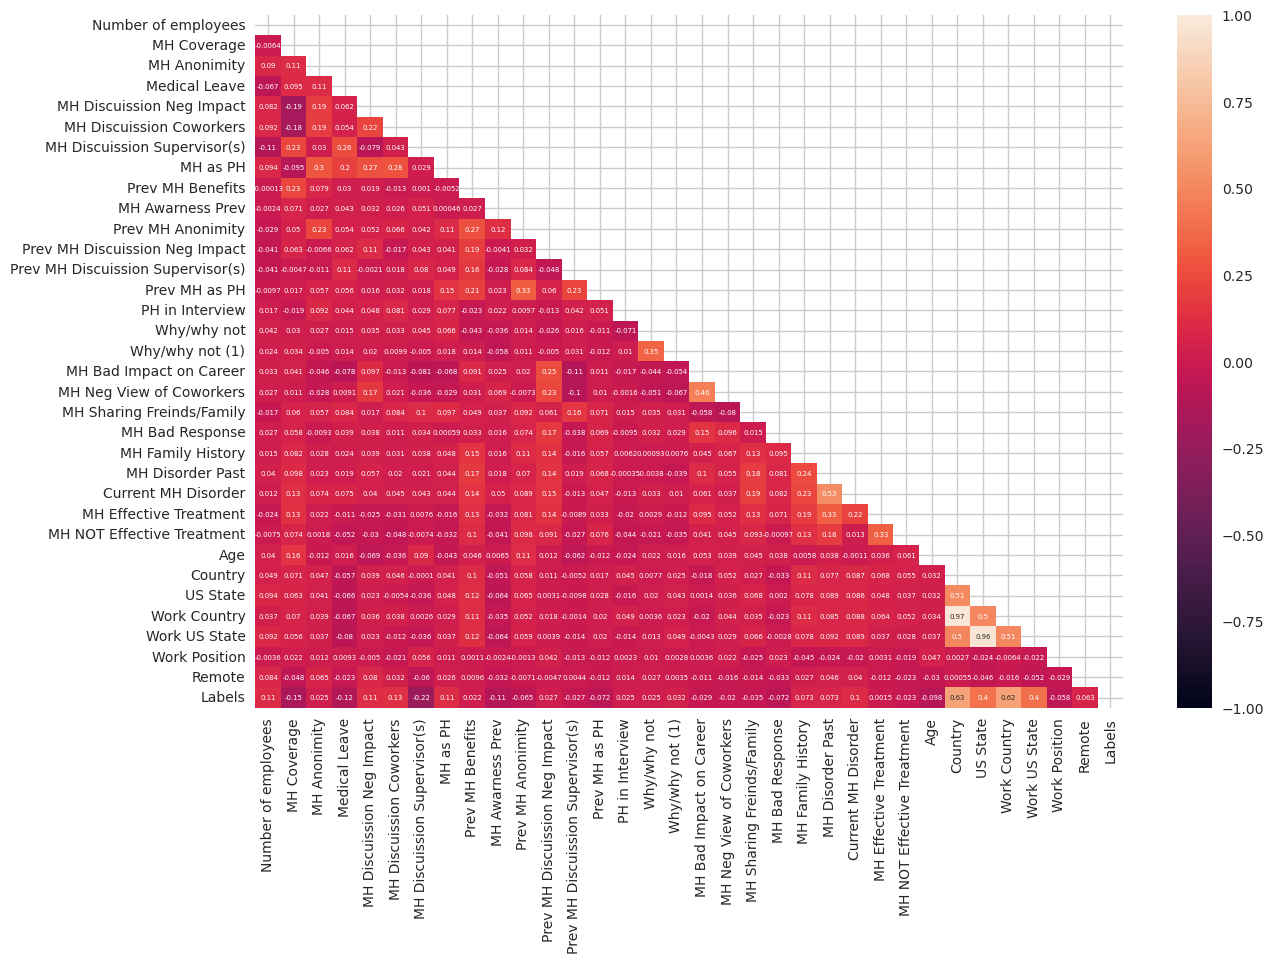

In [50]:
plt.figure(figsize=(14, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, vmin=-1, vmax=1, mask=mask, annot=True, annot_kws={'size': 5})